This notebook generates the demo shown in the uncertainty analysis of other model families. The detailed experimental setup is provided in Supplementary Material Section 5.

In [ ]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

import torch

In [2]:
import random
import numpy as np
import matplotlib.pyplot as plt

from allen_cahn_equation import (
    compute_exact_solution_random_ic_vary_Nx,
    visualize_spline_ic,
    plot_both_grids,
)


from data_processing import (
    SimpleSerializerSettings, scale_2d_array, unscale_2d_array,
    serialize_2d_integers, deserialize_2d_integers, extract_training_and_test
)

from phi_utils import load_model_and_tokenizer, generate_text_multiple
from matplotlib.patches import Patch

MODEL_NAME = "microsoft/phi-4"
seed = 1
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

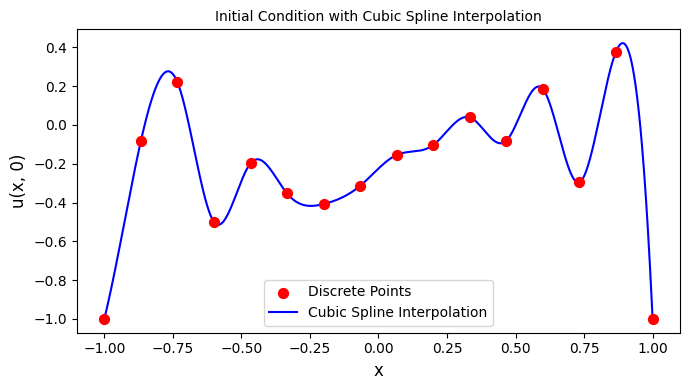

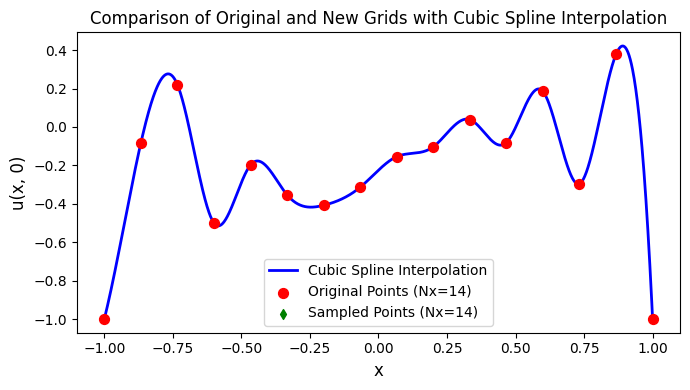

In [3]:
# Define parameters for the Allen-Cahn equation
L = 2       # Length of the spatial domain
k = 0.001   # Thermal diffusivity
T = 0.5     # Total simulation time
Nx = 14     # Number of spatial steps (excluding boundary points)
Nt = 2      # Number of time steps 
dx = L/(Nx+1)
dt = T/Nt

# Example: Demonstrating the process of generating and visualizing a random initial condition
init_cond_random = np.random.uniform(-0.5, 0.5, size=Nx)
fig = visualize_spline_ic(L, Nx, init_cond_random)
plt.tight_layout()
plt.show()

# Example: Demonstrating how to resample spatial points from an underlying random initial condition
Nx_original = Nx
Nx_new = 14
fig, cs, init_cond_random_new = plot_both_grids(L, Nx_original, Nx_new, init_cond_random)
plt.tight_layout()
plt.show()

# Serialization setup
settings = SimpleSerializerSettings(space_sep=",", time_sep=";")
# Serialize the entire exact solution for all time steps
u_exact = compute_exact_solution_random_ic_vary_Nx(L, k, T, Nx, Nt, spline_obj=cs)
u_exact_scaled, vmin_exact, vmax_exact = scale_2d_array(u_exact)
u_exact_serialized = serialize_2d_integers(u_exact_scaled, settings)
# Reconstruct the scaled data from the text
u_exact_parsed = deserialize_2d_integers(u_exact_serialized, settings)
u_exact_unscaled = unscale_2d_array(u_exact_parsed, vmin_exact, vmax_exact)

In [4]:
model, tokenizer = load_model_and_tokenizer(MODEL_NAME)

Loading checkpoint shards:   0%|          | 0/6 [00:00<?, ?it/s]

In [ ]:
def get_positive_tokens_int(logits, tokenizer, prob_threshold=1e-12):
    """
    For each token with probability > prob_threshold, return (integer_value, probability, token_id).
    """
    probs = torch.nn.functional.softmax(logits, dim=-1)
    above_threshold = (probs > prob_threshold).nonzero().flatten()
    result = []
    for idx in above_threshold:
        prob = probs[idx].item()
        token_id = idx.item()
        token_str = tokenizer.decode([token_id]).strip()
        if token_str == "<|end_of_text|>":
            continue
        try:
            val_int = int(token_str)
            result.append((val_int, prob, token_id))
        except ValueError:
            print(f"Skipping non-integer token '{token_str}' (ID: {token_id}) with probability {prob:.6f}")
            continue
    return result

In [ ]:
# Demo
input_time_steps_demo = 2
train_serial_demo, test_serial_demo = extract_training_and_test(
    u_exact_serialized, input_time_steps_demo, settings
)
# Generate text with scores
generated_token_demo, gen_output_demo = generate_text_multiple(
    prompt=train_serial_demo,
    model=model,
    tokenizer=tokenizer,
    Nx=Nx,
)

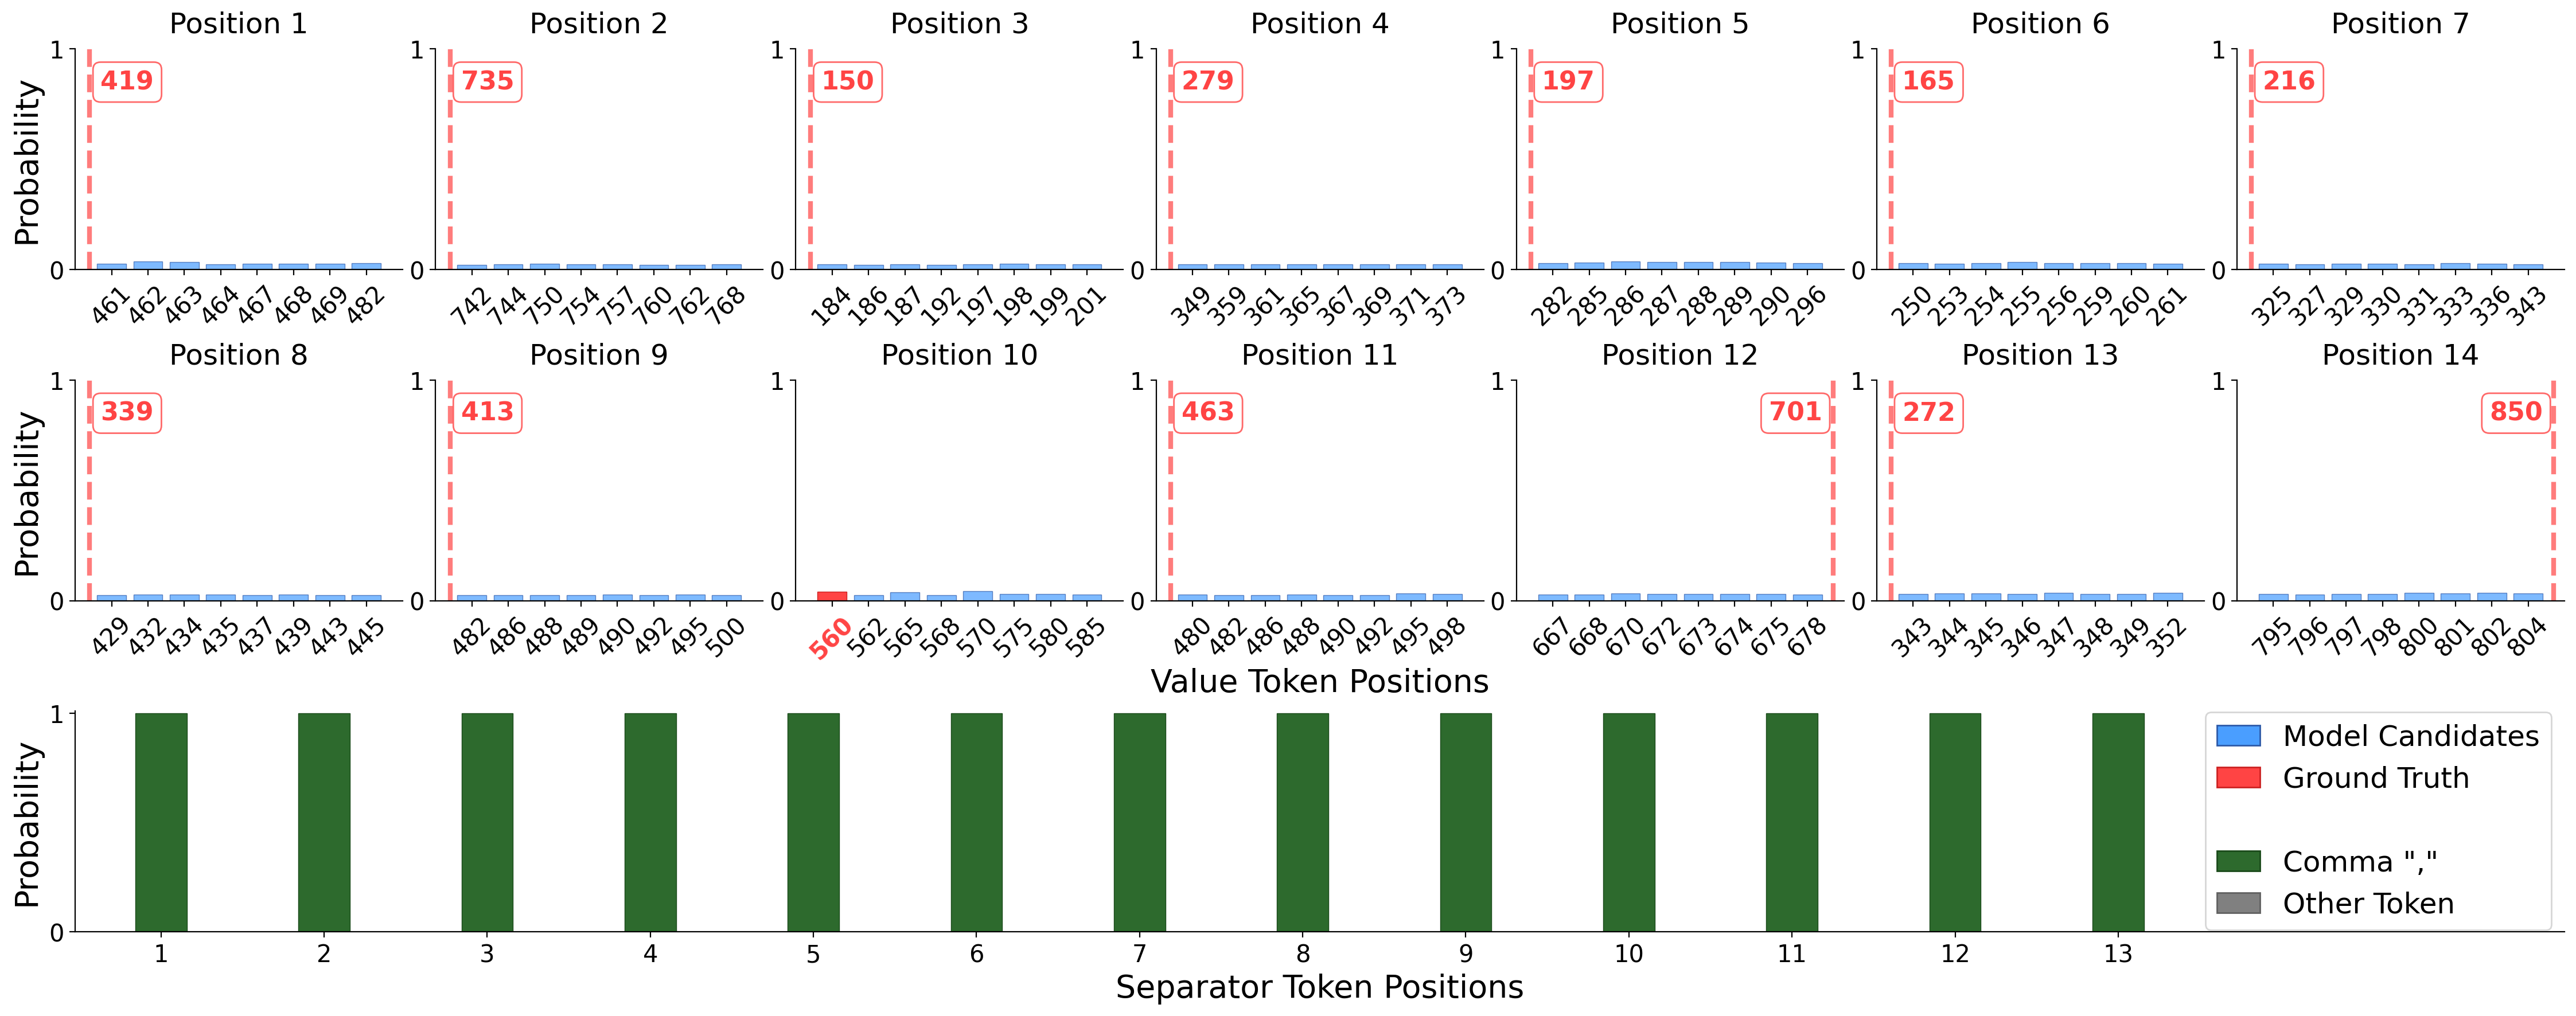

In [7]:
def plot_all_token_probabilities(generation_output, tokenizer, ground_truth_str, prob_threshold=1e-16):
    # Parse ground truth into individual numbers
    numbers = ground_truth_str.split(",")
    n_steps = len(generation_output.scores)
    # Get numerical positions (even indices in scores array)
    numerical_indices = [i for i in range(n_steps) if i % 2 == 0]
    comma_indices = [i for i in range(n_steps) if i % 2 == 1]
    fig = plt.figure(figsize=(28, 10), dpi=200)
    gs = fig.add_gridspec(3, 7, height_ratios=[1, 1, 1], hspace=0.5, wspace=0.1)
    for pos_idx, step_idx in enumerate(numerical_indices):
        if pos_idx < 7:
            row = 0
            col = pos_idx
        else:
            row = 1
            col = pos_idx - 7
        ax = fig.add_subplot(gs[row, col])
        ax.set_yticks([0, 1])
        ax.set_yticklabels(['0', '1'])
        # Get numerical tokens above threshold
        logits = generation_output.scores[step_idx][0]
        int_tokens = get_positive_tokens_int(logits, tokenizer, prob_threshold)
        # Get ground truth for this position
        gt_token = numbers[step_idx // 2] if step_idx // 2 < len(numbers) else ""
        gt_value = int(gt_token) if gt_token.isdigit() else None
        if int_tokens:
            # Sort by probability, take top 8, then sort by value
            int_tokens.sort(key=lambda x: x[1], reverse=True)
            int_tokens = int_tokens[:8]
            int_tokens.sort(key=lambda x: x[0])
            tokens = [f"{val:03d}" for val, _, _ in int_tokens]
            values = [val for val, _, _ in int_tokens]
            probs = [prob for _, prob, _ in int_tokens]
            single_dominant = len(probs) == 1 or (len(probs) > 1 and probs[0] > 0.99)
            if single_dominant and len(probs) == 1:
                bar_width = 0.1
                bar_center = 0.5
                x_positions = [bar_center]
                bar_left = bar_center - bar_width/2
                bar_right = bar_center + bar_width/2
                is_target = (gt_value is not None and values[0] == gt_value)
                bar_color = '#ff4444' if is_target else '#4a9eff'
                edge_color = '#cc2222' if is_target else '#2d5aa8'
                bars = ax.bar(x_positions, probs[:1], width=bar_width, 
                             color=bar_color, edgecolor=edge_color, linewidth=0.5)
                # Show target as dashed line if prediction doesn't match
                if gt_value is not None and values[0] != gt_value:
                    predicted_val = values[0]
                    if gt_value < predicted_val:
                        diff = predicted_val - gt_value
                        if diff <= 10:
                            target_x = bar_left - 0.05
                        elif diff <= 50:
                            target_x = bar_left - 0.05 - (diff - 10) * 0.004
                        else:
                            target_x = bar_left - 0.21 - min((diff - 50) * 0.001, 0.15)
                    else:
                        diff = gt_value - predicted_val
                        if diff <= 10:
                            target_x = bar_right + 0.05
                        elif diff <= 50:
                            target_x = bar_right + 0.05 + (diff - 10) * 0.004
                        else:
                            target_x = bar_right + 0.21 + min((diff - 50) * 0.001, 0.15)
                    target_x = max(0.05, min(0.95, target_x))
                    ax.axvline(x=target_x, color='#ff4444', linewidth=3, linestyle='--', alpha=0.7)
                ax.set_xlim(0, 1)
                ax.set_xticks(x_positions)
                ax.set_xticklabels(tokens[:1])
                # Add ground truth label
                if gt_value is not None and values[0] != gt_value:
                    y_pos = 0.85
                    if target_x < bar_left - 0.1:
                        label_x = target_x + 0.03
                        ha = 'left'
                    elif target_x > bar_right + 0.1:
                        label_x = target_x - 0.03
                        ha = 'right'
                    else:
                        label_x = target_x + 0.03 if target_x > bar_center else target_x - 0.03
                        ha = 'left' if target_x > bar_center else 'right'
                    ax.text(label_x, y_pos, f'{gt_value:03d}', 
                           color='#ff4444', fontsize=16, fontweight='bold',
                           ha=ha, va='center',
                           bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='#ff4444', alpha=0.8))
            else:
                # Multi-token display
                colors = []
                edge_colors = []
                target_idx = None
                for i, val in enumerate(values):
                    if gt_value is not None and val == gt_value:
                        target_idx = i
                        colors.append('#ff4444')
                        edge_colors.append('#cc2222')
                    else:
                        colors.append('#4a9eff')
                        edge_colors.append('#2d5aa8')
                offset = (8 - len(tokens)) / 2
                x_positions = [i + offset for i in range(len(tokens))]
                bars = ax.bar(x_positions, probs, color=colors, edgecolor=edge_colors, linewidth=0.5, width=0.8)
                
                ax.set_xticks(x_positions)
                ax.set_xticklabels(tokens, rotation=45, ha='center')
                ax.set_xlim(-1.0, 8.0)
                if gt_value is not None and target_idx is None:
                    offset = (8 - len(tokens)) / 2
                    if gt_value < values[0]:
                        target_x = offset - 0.6
                    elif gt_value > values[-1]:
                        target_x = offset + len(values) - 0.3
                    else:
                        for i in range(len(values) - 1):
                            if values[i] < gt_value < values[i + 1]:
                                target_x = offset + i + 0.5
                                break
                    ax.axvline(x=target_x, color='#ff4444', linewidth=3, linestyle='--', alpha=0.7)
                    y_pos = 0.85
                    x_offset = 0.3
                    if target_x > offset + len(values) - 0.5:
                        x_offset = -0.3
                        ha = 'right'
                    else:
                        ha = 'left'
                    ax.text(target_x + x_offset, y_pos, f'{gt_value:03d}', 
                           color='#ff4444', fontsize=16, fontweight='bold',
                           ha=ha, va='center',
                           bbox=dict(boxstyle='round,pad=0.3', facecolor='white', 
                                   edgecolor='#ff4444', alpha=0.8))
                elif target_idx is not None:
                    for i, label in enumerate(ax.get_xticklabels()):
                        if i == target_idx:
                            label.set_color('#ff4444')
                            label.set_fontweight('bold')
                for bar, prob, val in zip(bars, probs, values):
                    if not (gt_value is not None and val == gt_value):
                        bar.set_alpha(0.7 + 0.3 * prob)
            
        else:
            # No predictions meet threshold
            ax.bar([], [])
            if gt_value is not None:
                ax.axvline(x=0.5, color='#ff4444', linewidth=3, linestyle='--', alpha=0.7)
                ax.text(0.58, 0.85, f'{gt_value:03d}', 
                       color='#ff4444', fontsize=16, fontweight='bold',
                       ha='left', va='center',
                       bbox=dict(boxstyle='round,pad=0.3', facecolor='white', 
                               edgecolor='#ff4444', alpha=0.8))
                ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        ax.set_title(f"Position {pos_idx + 1}", fontsize=18, pad=10)
        if col == 0:
            ax.set_ylabel("Probability", fontsize=20)
        if row == 1 and col == 3:
            ax.set_xlabel("Value Token Positions", fontsize=20)
        ax.tick_params(axis='x', labelsize=15)
        ax.tick_params(axis='y', labelsize=15)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
    
    # Bottom subplot for delimiter
    ax_comma = fig.add_subplot(gs[2, :])
    ax_comma.set_yticks([0, 1])
    ax_comma.set_yticklabels(['0', '1'])
    position_labels = []
    comma_probs = []
    other_token_max_probs = []
    other_token_names = []
    for i, step_idx in enumerate(comma_indices):
        logits = generation_output.scores[step_idx][0]
        probs = torch.nn.functional.softmax(logits, dim=-1)
        comma_id = tokenizer.encode(",", add_special_tokens=False)[0]
        comma_prob = probs[comma_id].item()
        probs_copy = probs.clone()
        probs_copy[comma_id] = 0
        max_other_idx = probs_copy.argmax().item()
        max_other_prob = probs_copy[max_other_idx].item()
        max_other_token = tokenizer.decode([max_other_idx]).strip()
        position_labels.append(f"{i+1}")
        comma_probs.append(comma_prob)
        other_token_max_probs.append(max_other_prob)
        other_token_names.append(max_other_token)
    x = np.arange(len(position_labels)) * 0.95
    width = 0.3
    bars1 = ax_comma.bar(x, comma_probs, width, label='Comma ","', color='#2d6a2d', edgecolor='#1a4a1a', linewidth=0.5)
    bars2 = ax_comma.bar(x, other_token_max_probs, width, label='Other Token', color='#808080', edgecolor='#606060', linewidth=0.5)
    ax_comma.set_xlim(-0.5, len(position_labels)+1) 
    ax_comma.set_ylabel('Probability', fontsize=20)
    ax_comma.set_xticks(x)
    ax_comma.set_xticklabels(position_labels)
    ax_comma.set_xlabel('Separator Token Positions', fontsize=20)
    ax_comma.set_ylim(0, 1.01)
    ax_comma.tick_params(axis='x', labelsize=15)
    ax_comma.tick_params(axis='y', labelsize=15)
    legend_elements = [
        Patch(facecolor='#4a9eff', edgecolor='#2d5aa8', label='Model Candidates'),
        Patch(facecolor='#ff4444', edgecolor='#cc2222', label='Ground Truth'),
        Patch(facecolor='none', edgecolor='none', label=''),
        Patch(facecolor='#2d6a2d', edgecolor='#1a4a1a', label='Comma ","'),
        Patch(facecolor='#808080', edgecolor='#606060', label='Other Token')
    ]
    ax_comma.legend(handles=legend_elements, fontsize=18, bbox_to_anchor=(0.85, 1.06), 
                    handlelength=1.5, ncol=1)
    for i, (bar1, bar2) in enumerate(zip(bars1, bars2)):
        if comma_probs[i] < 0.999:
            ax_comma.text(bar1.get_x() + bar1.get_width()/2., bar1.get_height() + 0.01,
                        f'{comma_probs[i]:.3f}', ha='center', va='bottom', fontsize=16)
        if other_token_max_probs[i] > 0.0001:
            label = f'{other_token_max_probs[i]:.3f}'
            if len(other_token_names[i]) <= 3 and other_token_names[i]:
                label = f'"{other_token_names[i]}"\n{label}'
            ax_comma.text(bar2.get_x() + bar2.get_width()/2., bar2.get_height() + 0.01,
                        label, ha='center', va='bottom', fontsize=16)
    ax_comma.spines['top'].set_visible(False)
    ax_comma.spines['right'].set_visible(False)

    plt.show()
    return fig

fig = plot_all_token_probabilities(gen_output_demo, tokenizer, test_serial_demo)